In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import functools
import itertools
import shelve

import simpy
import scipy.stats
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [9]:
def patch_resource(resource, pre=None, post=None):
    """Patch *resource* so that it calls the callable *pre* before each
    put/get/request/release operation and the callable *post* after each
    operation. The only argument to these functions is the resource
    instance.

    """
    def get_wrapper(func):
        # Generate a wrapper for put/get/request/release
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            # This is the actual wrapper
            # Call "pre" callback
            if pre:
                pre(resource)

            # Perform actual operation
            ret = func(*args, **kwargs)

            # Call "post" callback
            if post:
                post(resource)

            return ret
        return wrapper

    # Replace the original operations with our wrapper
    for name in ['put', 'get', 'request', 'release']:
        if hasattr(resource, name):
            setattr(resource, name, get_wrapper(getattr(resource, name)))
    return resource


def monitor(data, resource):
    """This is our monitoring callback."""
    data.append({
        "clock": resource._env.now,
        "usage": resource.count,
        "queue": len(resource.queue),
        "total": resource.count + len(resource.queue)
    })

In [10]:
def sampler(data):
    kde = sm.nonparametric.KDEUnivariate(data)
    kde.fit()
    icdf = scipy.interpolate.interp1d(np.linspace(0, 1, num=kde.icdf.size), kde.icdf)
    return lambda: icdf(np.random.uniform(0, 1))


def interarrival_sampler(partition):
    sdata = pd.read_csv("../../data/squeued.20211111.mergedparts.csv")
    sdata = sdata[sdata.MERGED_PARTITION == partition].sort_values(by="SUBMIT_TIME")
    # Compute interarrival times in hours.
    interarrival_times = (pd.to_datetime(sdata["SUBMIT_TIME"]).sort_values().diff().dropna() / np.timedelta64(1, "h")).values
    return sampler(interarrival_times)


def service_sampler(partition):
    sdata = pd.read_csv("../../data/squeued.20211111.mergedparts.csv")
    sdata = sdata[sdata.MERGED_PARTITION == partition].sort_values(by="SUBMIT_TIME")
    # Compute service times in hours.
    service_times = (pd.to_timedelta(sdata["SERVICE_TIME"]) / np.timedelta64(1, "h")).values
    return sampler(service_times)


def nodes_sampler():
    with shelve.open("../../data/squeued.20211125.shelf") as db:
        df = pd.DataFrame(db.values())
    smplr = sampler(df.NODES)
    return lambda: int(smplr())


def get_capacity(partition):
    sdata = pd.read_csv("../../data/squeued.20211111.mergedparts.csv")
    sdata = sdata[sdata.MERGED_PARTITION == partition].sort_values(by="SUBMIT_TIME")
    return len(sdata.EXEC_HOST.unique())

In [11]:
def simulate(partition="24core", until=24 * 30):
    interarrival = interarrival_sampler(partition)
    service = service_sampler(partition)
    nodes = nodes_sampler()
    capacity = get_capacity(partition)
    
    def source(env, partition):
        cntr = itertools.count(start=0)
        while True:
            yield env.timeout(interarrival())
            # A job has arrived.
            env.process(job(env, partition, next(cntr), nodes()))


    def job(env, partition, idx, num_nodes):
        # For each requested node...
        requests = []
        for _ in range(num_nodes):
            # ... reserve a free machine.
            requests.append(partition.request())
        # We have reserved enough machine. We can now run the job.
        yield env.timeout(service())
        for i in range(num_nodes):
            # Release the machines.
            partition.release(requests[i])
            

    data = []
    env = simpy.Environment()
    partition = patch_resource(
        simpy.Resource(env, capacity=round(capacity)),
        pre=functools.partial(monitor, data)
    )
    env.process(source(env, partition))
    env.run(until=until)
    return pd.DataFrame(data).set_index("clock")

array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

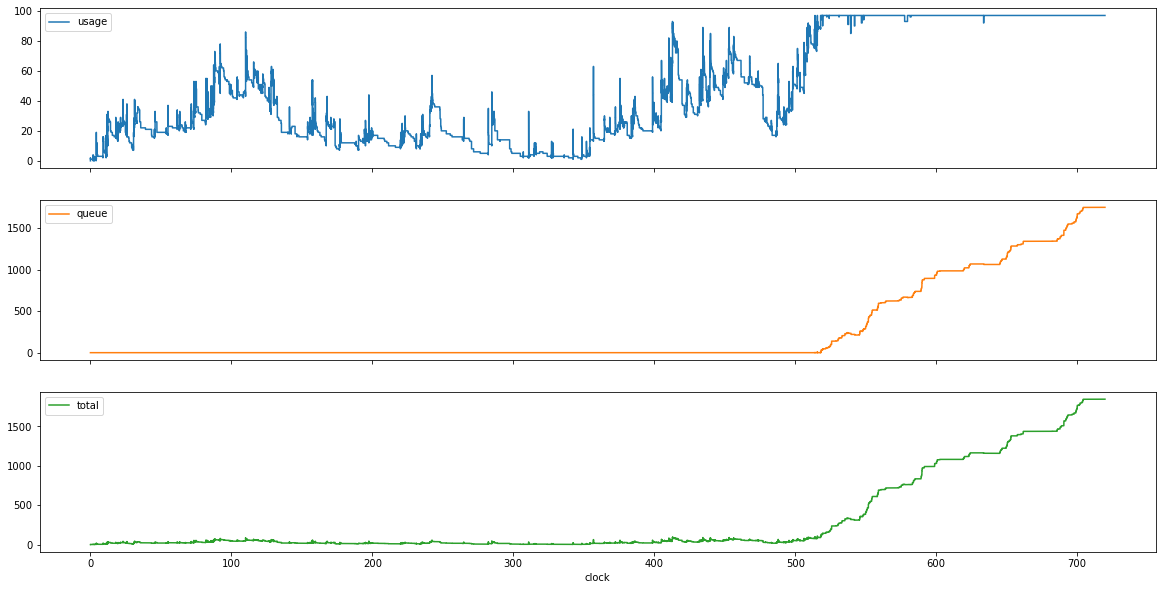

In [13]:
simulate("24core").plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

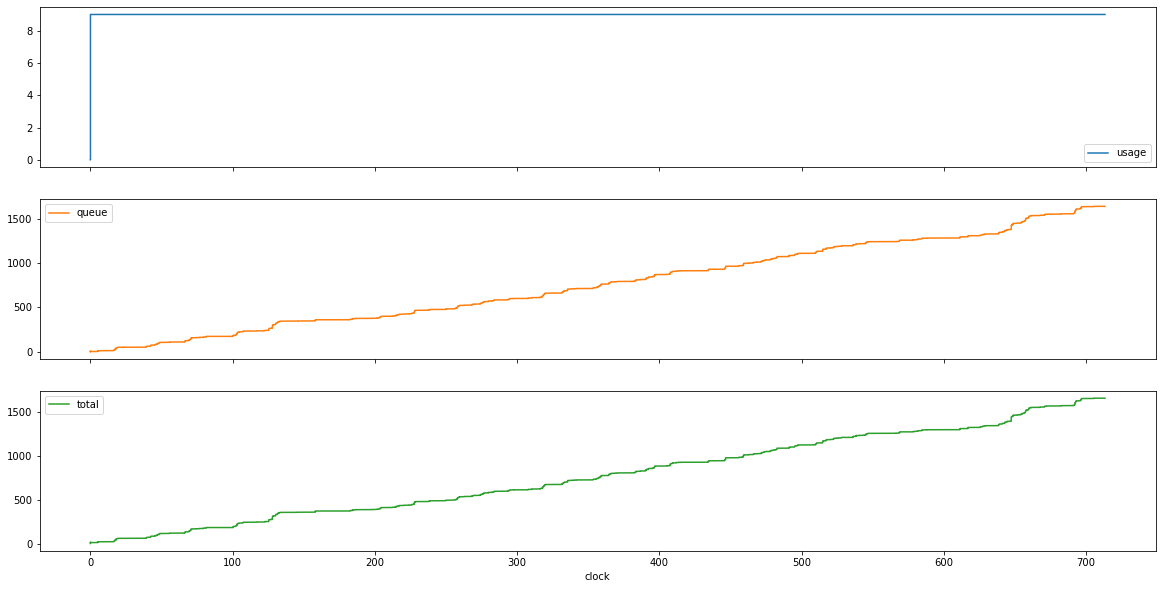

In [21]:
simulate("gpu").plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

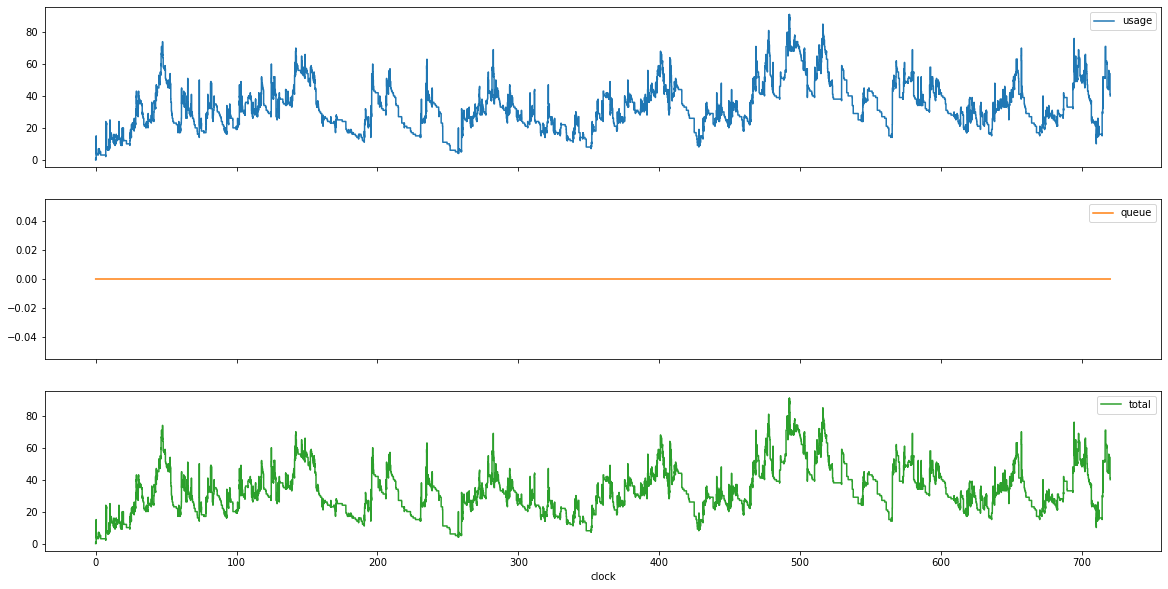

In [22]:
simulate("28core").plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)

array([<AxesSubplot:xlabel='clock'>, <AxesSubplot:xlabel='clock'>,
       <AxesSubplot:xlabel='clock'>], dtype=object)

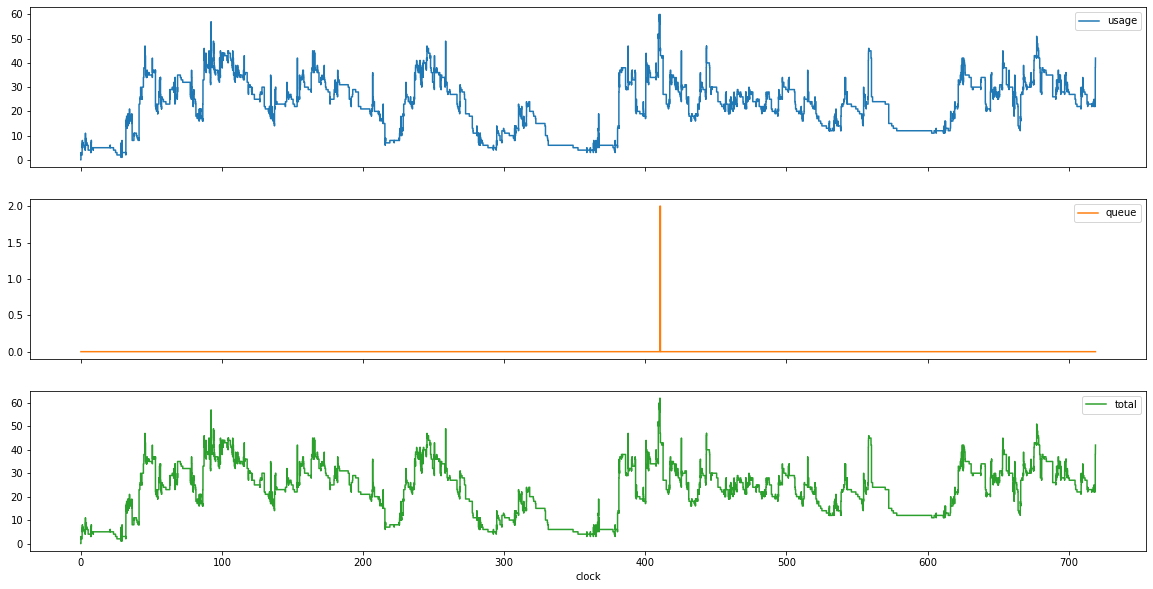

In [23]:
simulate("40core").plot(figsize=(20, 10), drawstyle="steps-post", subplots=True)